<a href="https://colab.research.google.com/github/rafaelnduarte/Sales_Forecast_Prophet/blob/master/Sales_Forecast_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Forecast Using Prophet
[![LinkedIn](https://img.shields.io/badge/LinkedIn-rafaelnduarte-blue.svg)](https://www.linkedin.com/in/rafael-n-duarte)
[![GitHub](https://img.shields.io/badge/GitHub-rafaelnduarte-purple.svg)](https://github.com/rafaelnduarte)

In this project, the goal is to use the data made available by a UK Retailer to show how we can leverage Data Science Solutions to have competitive advantages over other businesses.

Also, this brings us greater knowledge on the company itself, helping us better understand the customers, their habits, the products, etc.

[Source of the data](https://www.kaggle.com/carrie1/ecommerce-data/kernels)

[Reference](https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17)


<center><img width="60%" src="https://image.freepik.com/free-vector/consumers-isometric-composition_1284-26384.jpg"></center>


> The objective is to show how Data Science can be used as a powerful tool and create competitive advantages for businesses.

Here, we'll work on:
* Analysis of sales over time, as well as Sales Forecast using Prophet.
* [RFM Customer Segmentation - K-Means]('https://colab.research.google.com/drive/1NEpuPYEtRo2rV80NU-DhgQ4OBbP4aAic')
* [Understanding Your Customers with NLP]('https://colab.research.google.com/drive/1CHPEvQ7h43YBMiScttRjEXQV3WbZeB_t#scrollTo=64NxqUV8eYlI')

Let's get started!



In [2]:
#@title Importing Packages
# importing the necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import datetime as dt
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
import scipy.stats as scs

import warnings
warnings.filterwarnings("ignore")
sns.set_style()
%matplotlib inline

# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## The Data

As stated before, we're using a UK retailer's data, made available on Kaggle. It contains sales data from 2010 to 2011. Even though it's not the most recent dataset out there, it gets the job done since it helps us show that even with only 8 features we can create great value.

### Data Dictionary
* `InvoiceDate`- Date and time of the purchase.
* `InvoiceNo` - Invoice identification number.
* `StockCode`- Stock code for the product.
* `Description` - Brief description of the product.
* `Quantity` - Quantity of items purchased.
* `UnitPrice` - Unit price for a given product in Pounds Sterling.
* `CurtomerID` - ID of the customer making the purchase.
* `Country` - Country where the purchase was made.

In [3]:
# importing the data
path = ('https://www.dropbox.com/s/c1ezwqycnas2fmb/data.csv?dl=1')

df = pd.read_csv(path, encoding='latin-1')

# transforming into datetime
df.index = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)

df.drop('InvoiceDate', axis=1, inplace=True)

# checking the dataset
df.head()


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom


In [4]:
# checking the shape of the dataset
print('Features:', df.shape[1])
print('Entries:', df.shape[0])

Features: 7
Entries: 541909


In [5]:
# checking for missing data and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541909 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   UnitPrice    541909 non-null  float64
 5   CustomerID   406829 non-null  float64
 6   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# checking for missing values
(df.isnull().sum()/ df.shape[0]).sort_values(ascending=False)

CustomerID     0.249267
Description    0.002683
Country        0.000000
UnitPrice      0.000000
Quantity       0.000000
StockCode      0.000000
InvoiceNo      0.000000
dtype: float64

Ok, this will need some work.

25% of missing values on customer data is quite significant, and trying to predict them would be too arbitrary. We're better off just deleting them.

Description, on the other hand is so insignificant, that we jus won't bother trying to deal with it.

So, we're getting rid of these lines.

In [7]:
df_clean = df.copy()

df_clean.dropna(axis=0, inplace=True)

df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom


In [8]:
# checking for missing values
(df_clean.isnull().sum()/ df_clean.shape[0]).sort_values(ascending=False)

Country        0.0
CustomerID     0.0
UnitPrice      0.0
Quantity       0.0
Description    0.0
StockCode      0.0
InvoiceNo      0.0
dtype: float64

### Fixing some data
The variable `Quantity` has negative values, which makes no sense. To fix that, we're going to drop the rows that have negative values for quantity.

Also, we're going to set `CustomerID` to integer.

Finally, we're going to transform `Description` to lower case.

In [0]:
# fixing Quantity
df_clean = df_clean[df_clean.Quantity > 0]

# fixing CustomerID
df_clean['CustomerID'] = df_clean['CustomerID'].astype('int64')

In [0]:
# converting to lower case
df_clean['Description'] = df_clean.Description.str.lower()

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397924 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   UnitPrice    397924 non-null  float64
 5   CustomerID   397924 non-null  int64  
 6   Country      397924 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 24.3+ MB


Now that we have dealt with our missing values, let's start exploring our data

### Creating some features

An interesting way to enrich our data exploration and boost our model's performance is to create new features. In our dataset we have access to the quantity and price of products, so we can come up with the amount spent on each item. We'll call it `AmountSpent`.

In [0]:
# creating a new features
df_clean['AmountSpent'] = df_clean['Quantity'] * df_clean['UnitPrice']

In [13]:
# checking the data
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,AmountSpent
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,white hanging heart t-light holder,6,2.55,17850,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,white metal lantern,6,3.39,17850,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,knitted union flag hot water bottle,6,3.39,17850,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,red woolly hottie white heart.,6,3.39,17850,United Kingdom,20.34


### Basic EDA

The goal of this project is not to be an extensive exploration and analysis of the data, but rather a quick, easy to understand yet powerful solution that can be improved and implemented for testing.

With that said, our exploration will be enough for us to understand our data, but won't dive deep into every detail of the data.

Let's get started

In [14]:
# statistical distribution of the data
df_clean.describe()

,Quantity,UnitPrice,CustomerID,AmountSpent
count,397924.000000,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171,22.394749
std,180.420210,22.096788,1713.169877,309.055588
min,1.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13969.000000,4.680000
50%,6.000000,1.950000,15159.000000,11.800000
75%,12.000000,3.750000,16795.000000,19.800000
max,80995.000000,8142.750000,18287.000000,168469.600000


#### Statistical Distribution Highlights
* `Price`
  * The minimum price is £ 0,00, which means that the store gives out some items.
  * The average price of the products is £ 3,11.
  * The most expensive item costs £ 8.142,75.
  * Even though there are expensive items, most of them are cheap.
* `Quantity`
  * The average is actually above the 75th percentile, which indicates that most purchases are made in larger quantities. The source of the data says that this store caters to wholesalers. Even though this could explain it, they're not the only type of customers, since the average is not wholesale worthy.
* `AmountSpent`
  * In this regard, it's really interesting to see again, that the spending pattern is actually cheap. Of course, we don't have data on entire orders, but people don't tend to spend a lot on the items.


In [15]:
# statistical distribution of categorical features
df_clean.describe(include='O')

,InvoiceNo,StockCode,Description,Country
count,397924,397924,397924,397924
unique,18536,3665,3877,37
top,576339,85123A,white hanging heart t-light holder,United Kingdom
freq,542,2035,2028,354345


#### Checking Best Selling Products
With the data we have, it's easy to see our best selling items. Let's check them out.

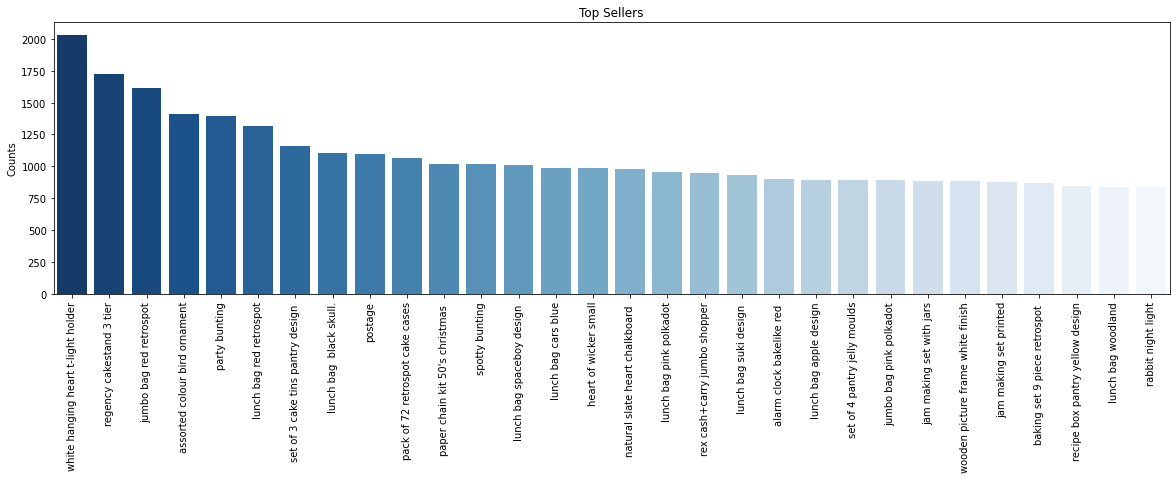

In [16]:
# checking best selling products
description_counts = df_clean.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette='Blues_r')
plt.ylabel("Counts")
plt.title("Top Sellers");
plt.xticks(rotation=90);

#### Best Selling Countries
We have seen that this business makes sales to 37 different countries. But what countries buy the most? That's easy to check:

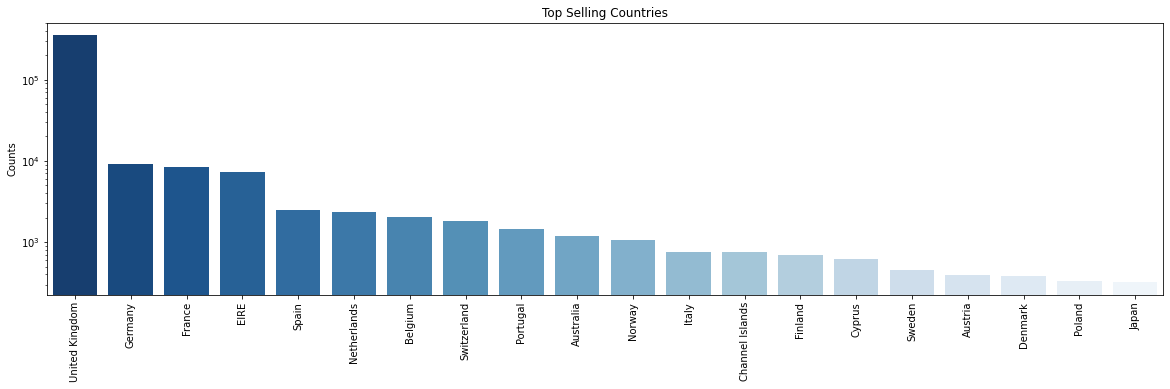

In [17]:
# best selling countries
country_counts = df_clean.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, palette="Blues_r")
plt.ylabel("Counts")
plt.title("Top Selling Countries");
plt.xticks(rotation=90);
plt.yscale("log")

#### Statistical Distribution of Categorical Features

* This company sells to 37 different countries around the world.
* Again, the number of unique Invoice Numbers vs the quantity of rows shows that most invoices have lots of products, once again reinforcing the idea of wholesalers.
* Being UK based, it makes sense that it sells the most to the UK.
* They carry almost 4.000 different products.

### Conclusions
Since we're going to work on different aspects of this business, delivering different kinds of analysis, this is not supposed to be an extensive analysis, but rather an overview of the data set. 

[Here](https://colab.research.google.com/drive/1CHPEvQ7h43YBMiScttRjEXQV3WbZeB_t) we can take a look at some basic NLP exploration, to better understand the products and the markets.

## Time Series Analysis

<center><img width="40%" src="https://image.freepik.com/free-vector/variety-time-objects-man-landing-page_52683-23310.jpg"></center>


As you could see from the beginning of the analysis, we're dealing with **Time Series** here. 

Time Series are sequences of observations registered in a regular period of time.

This is a bid deal because we measure everything in time. In this case, we're talking about sales over a given period of time.

### Real Business Applications

The dataset we're using is from a UK retailer on their sales over a period of time. In the real world, they would use this data for:
* Analyzing previous periods to see what went right and wrong (BI)
* Use this data to make predictions for the future (Data Science)

Ok. But are these predictions any good? Are they a guarantee of anything?

They don't guarantee anything, especially because we're not analyzing exterior factors like weather, disasters, fires, and whatnot. Nevertheless, they can be a reliable source of information, that can help with:

* Stock
* Business strategies for new products, sales, etc.
* Marketing

And a lot more.

First, let's prepare our data, and then dive into Machine Learning.

In [18]:
# creating new features to help with the Time Series Analysis
df_clean["Year"] = df_clean.index.year
df_clean["Quarter"] = df_clean.index.quarter
df_clean["Month"] = df_clean.index.month
df_clean["Week"] = df_clean.index.week
df_clean["Weekday"] = df_clean.index.weekday
df_clean["Day"] = df_clean.index.day
df_clean["Dayofyear"] = df_clean.index.dayofyear
df_clean["Date"] = pd.DatetimeIndex(df_clean.index).date

# checking new features
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,AmountSpent,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
InvoiceDate,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,white hanging heart t-light holder,6,2.55,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,71053,white metal lantern,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850,United Kingdom,22.00,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,84029G,knitted union flag hot water bottle,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,84029E,red woolly hottie white heart.,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01


In [0]:
# convert variables to either 0 or 1
df_clean['Weekend'] = 0
df_clean.loc[(df_clean.Weekday == 5) | (df_clean.Weekday == 6), 'Weekend'] = 1

In [20]:
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,AmountSpent,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,Weekend
InvoiceDate,,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,white hanging heart t-light holder,6,2.55,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,71053,white metal lantern,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850,United Kingdom,22.00,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,84029G,knitted union flag hot water bottle,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
2010-12-01 08:26:00,536365,84029E,red woolly hottie white heart.,6,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0


Great! Now we have a lot more information. Let's analyze how sales change over the week.

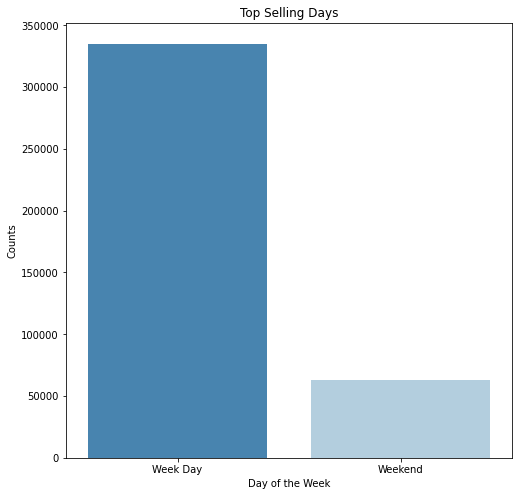

In [21]:
# checking values for weekdays and weekends
weekend_counts = df_clean.Weekend.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(weekend_counts.index, weekend_counts.values, palette="Blues_r")
plt.ylabel("Counts")
plt.xlabel("Day of the Week")
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'Weekend'
labels[0] = 'Week Day'
ax.set_xticklabels(labels)
plt.title("Top Selling Days");

Surprisingly, this company sells way more on weekdays when comparing to weekends. Of course these numbers don't jump at you, when you consider there are more days on a week than on a weekend. However, on average, the company has sold, on average:
* 31.387,5 items a day on weekends.
* 67.029,8 items a day on weekdays.

For our analysis and prediction, let's focus on **Daily Sales**.

So, let's group our sales by product per day.

In [0]:
# creating grouped features
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

In [23]:
# creating daily features
daily_data = pd.DataFrame(df_clean.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["AmountSpent"] = df_clean.groupby(grouped_features).AmountSpent.sum()
daily_data = daily_data.reset_index()
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,AmountSpent
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,15044B,1,2.95
4,2010-12-01,2010,4,12,48,2,335,1,15056BL,20,113.00


In [24]:
# statistical distribution of the grouped data
daily_data.loc[:, ["Quantity", "AmountSpent"]].describe()

,Quantity,AmountSpent
count,222383.000000,222383.000000
mean,23.300774,40.072343
std,243.049757,418.467706
min,1.000000,0.000000
25%,3.000000,6.800000
50%,9.000000,15.800000
75%,24.000000,34.000000
max,80995.000000,168469.600000


As you can see, we have some **Outliers** that can influence our results on both ends of the dataset. For that reason, let's clean them up.

In [25]:
# identifying drop points
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 225.0)


In [26]:
# identifying drop points
low_AmountSpent = daily_data.AmountSpent.quantile(0.01)
high_AmountSpent = daily_data.AmountSpent.quantile(0.99)
print((low_AmountSpent, high_AmountSpent))

(0.76, 380.8143999999994)


In [0]:
# saving shape to count lost entries
samples = daily_data.shape[0]

In [0]:
# selecting entries
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.AmountSpent >= low_AmountSpent) & (daily_data.AmountSpent <= high_AmountSpent)]

In [29]:
# counting lost entries
samples - daily_data.shape[0]


5518

Awesome. Now that our data is clean, let's prepare a dataset for our forecasting.

In [0]:
# preparing the dataset for 
df_ts=daily_data.groupby('Date',as_index=False)['AmountSpent'].sum()
df_ts['Date'] = pd.to_datetime(df_ts['Date'], format="%Y-%m-%d")
df_ts.index = pd.to_datetime(df_ts['Date'], format="%Y-%m-%d")
df_ts.drop('Date', axis=1, inplace=True)

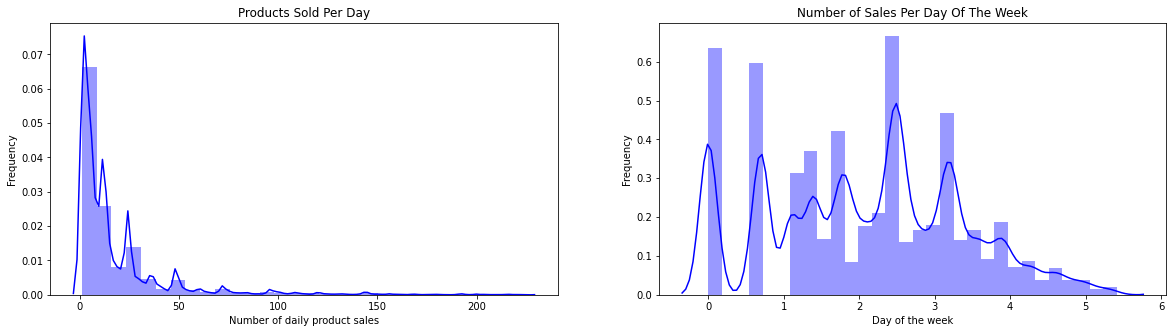

In [31]:
# 
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Blue", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Blue", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("Products Sold Per Day");
ax[1].set_xlabel("Day of the week");
ax[1].set_ylabel("Frequency");
ax[1].set_title("Number of Sales Per Day Of The Week");

## Preparing the Data for Machine Learning

<center><img width="60%" src="https://image.freepik.com/free-vector/gypsies-isometric-magic-background_1284-26453.jpg"></center>

For our forecast we'll use Facebook's **Prophet**.

It's a very robust and fairly simple model to use, that's powerful enough to render good results even with little to no tuning, when operating on the right data.

**Stationary Time Series**

When making predictions with Time Series, it's common to worry about whether they're stationary or not. Working with ARIMA, for example, this is essential.

You'll find examples of projects using Prophet without even checking to see if the Time Series is stationary or not. Here, we'll first work on it as is, and then check if it's stationary, if it's not, we'll make it so, and then train the model again to compare the results.

In [32]:
# checking our data
df_ts.head()

,AmountSpent
Date,
2010-12-01,31546.98
2010-12-02,32935.45
2010-12-03,19411.87
2010-12-05,28582.51
2010-12-06,23563.71


In [0]:
# importing Prophet
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

#### Working with Prophet

Prophet needs a very specific kind of dataframe for it to work on. What we need is:
* Date column as `ds`.
* Value column as `y`.

Let's make it so.

In [34]:
# setting up the dataframe
df_ts = df_ts.reset_index()
df_ts.columns = ['ds', 'y']
df_ts.head()

,ds,y
0,2010-12-01,31546.98
1,2010-12-02,32935.45
2,2010-12-03,19411.87
3,2010-12-05,28582.51
4,2010-12-06,23563.71


#### Stationary Test
As stated before, we'll analyze the effects of having a Stationary Time Series to work upon with Prophet.

First, let's check if our data is stationary.

In [35]:
from statsmodels.tsa.stattools import adfuller
# extracting values
X = df_ts.y

# apply ADF and print results
result = adfuller(X)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result[0]))
print('P Value: {:.10f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -1.4142
P Value: 0.5754323865
Critical Values:
	1%: -3.4530
	5%: -2.8715
	10%: -2.5721


Bingo. Our P value is at 0.57, which means our Time Series is **not** stationary.

Let's see how Prophet deals with it for our baseline.

In [0]:
# setting prediction size to 30 days
prediction_size = 30
train_df = df_ts[:-prediction_size]

In [37]:
# instantiating the model
b = Prophet()

# training the model
b.fit(train_df)

# make predictions
future = b.make_future_dataframe(periods=prediction_size)

forecast = b.predict(future)

forecast.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-12-01,18337.042917,11599.726328,26587.185197,18337.042917,18337.042917,259.022936,259.022936,259.022936,259.022936,259.022936,259.022936,0.0,0.0,0.0,18596.065853
1,2010-12-02,18340.334795,15199.305165,30396.782297,18340.334795,18340.334795,4109.187106,4109.187106,4109.187106,4109.187106,4109.187106,4109.187106,0.0,0.0,0.0,22449.521901
2,2010-12-03,18343.626673,8420.844859,24089.687639,18343.626673,18343.626673,-1944.987016,-1944.987016,-1944.987016,-1944.987016,-1944.987016,-1944.987016,0.0,0.0,0.0,16398.639658
3,2010-12-05,18350.210430,3530.946614,17853.859682,18350.210430,18350.210430,-8212.884378,-8212.884378,-8212.884378,-8212.884378,-8212.884378,-8212.884378,0.0,0.0,0.0,10137.326051
4,2010-12-06,18353.502308,10012.653083,24811.944938,18353.502308,18353.502308,-677.283404,-677.283404,-677.283404,-677.283404,-677.283404,-677.283404,0.0,0.0,0.0,17676.218904


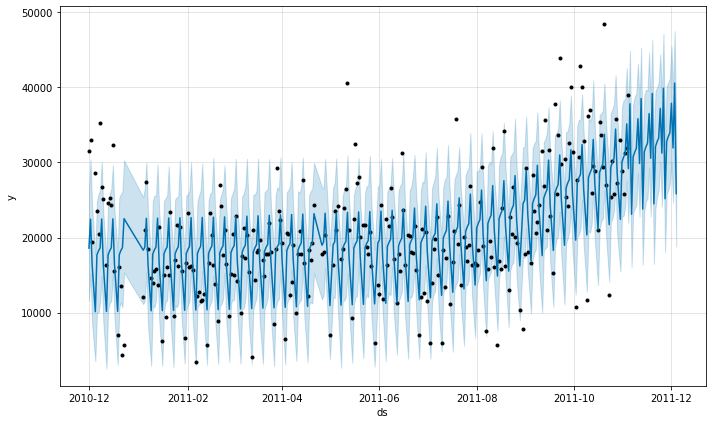

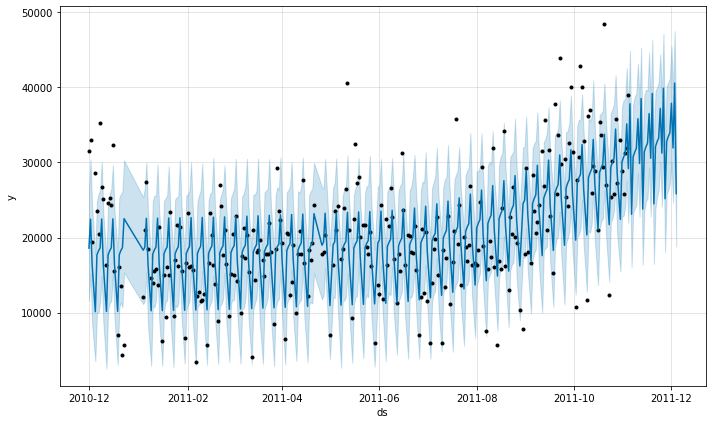

In [38]:
# plotting the forecast
b.plot(forecast)

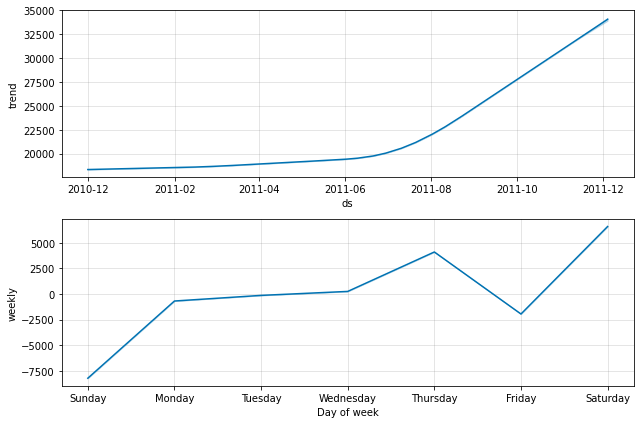

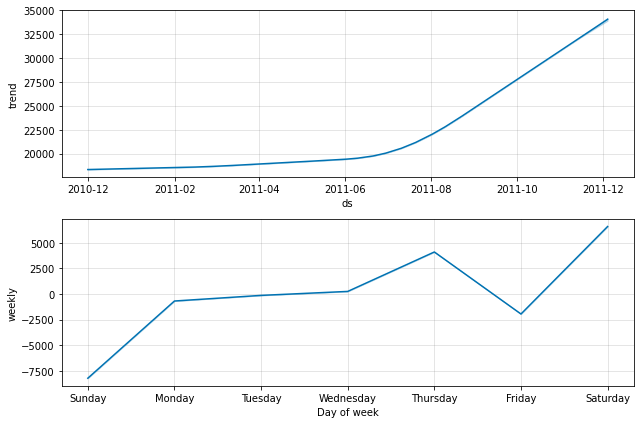

In [39]:
# plotting components
b.plot_components(forecast)

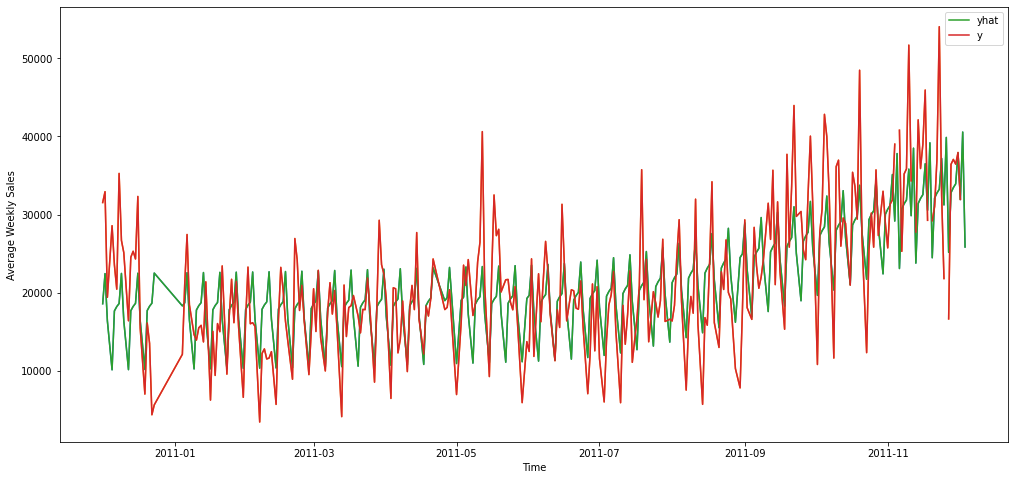

In [45]:
# checking the results
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(cmp_df['yhat'])
#plt.plot(cmp_df['yhat_lower'])
#plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])

plt.xlabel('Time')
plt.ylabel('Average Weekly Sales')
ax.plot(cmp_df['yhat'], label='yhat')
#ax.plot(cmp_df['yhat_lower'], label='yhat_lower')
#ax.plot(cmp_df['yhat_upper'], label='yhat_upper')
ax.plot(cmp_df['y'], label='y')
ax.legend()
plt.show()

In [41]:
# define a function to make a dataframe containing the predicion and actual values
def make_comparison_dataframe(historical, forecast):
  return forecast.set_index('ds')[['yhat', 'yhat_lower',
                                'yhat_upper']].join(historical.set_index('ds'))
cmp_df = make_comparison_dataframe(df_ts, forecast)

# define a function to calculate MAPE and MAE
def calculate_forecast_errors(df_ts, prediction_size):

  df = df_ts.copy()
  df['e'] = df['y'] - df['yhat']
  df['p'] = 100 * df['e'] / df['y']
  predicted_part = df[-prediction_size:]

  error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

  return{'MAPE': error_mean('p'), 'MAE': error_mean('e')}

# print the MAPE and MAE
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
  print(err_name, err_value)

MAPE 18.31634582652634
MAE 6253.813386052584


#### Conclusions
All of that seem great, however, how do we know if our predictions are any good?

Here, we're using to metrics for evaluation:
* Mean Absolute Percentage Error - How much do our predictions differ from the actual values in percentages.
* Mean Absolute Error - Absolute error value between the predicted value and the actual value.

# Stationary Time Series
This is quite a big error. We can't use it as a reliable source of information.

One of the things we can do to try and improve our results is making our Time Series stationary, and see how it goes.

We'll do that by using a technique called **Differencing**. You can find out more about this method [here](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/).

In [0]:
# preparing for transformation
df_ts.index = pd.to_datetime(df_ts['ds'], format="%Y-%m-%d")
df_ts.drop('ds', axis=1, inplace=True)
df_ts.head()

,y
ds,
2010-12-01,31546.98
2010-12-02,32935.45
2010-12-03,19411.87
2010-12-05,28582.51
2010-12-06,23563.71


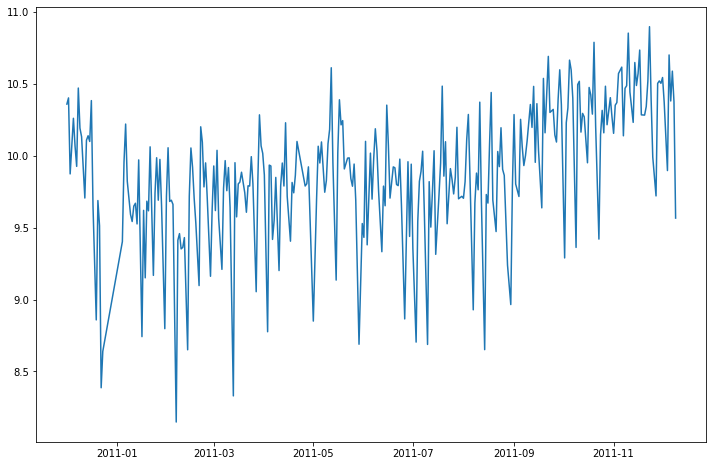

In [0]:
# log transformation
fig, ax = plt.subplots(figsize=(12,8))
ts_log = np.log(df_ts)
plt.plot(ts_log);

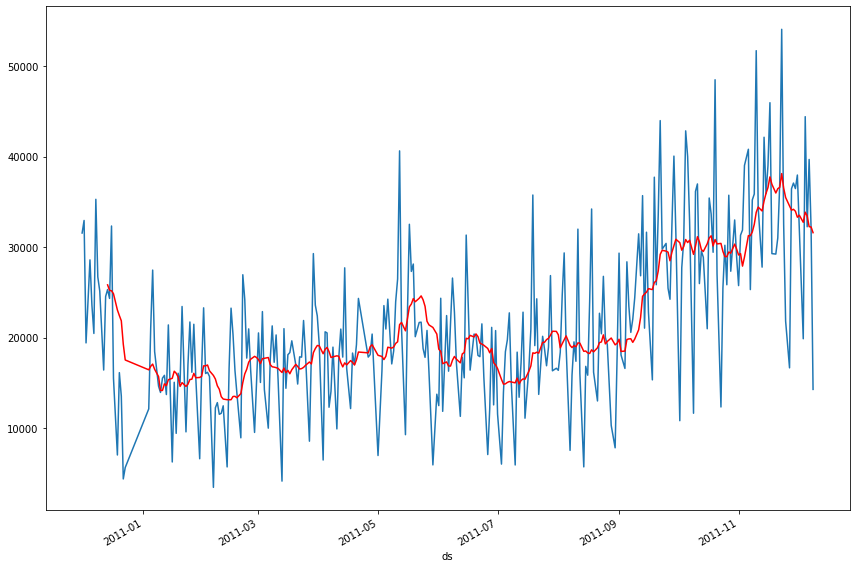

In [0]:
# check the original plot
ma = df_ts.rolling(12).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_ts.plot(ax=ax, legend=False)
ma.plot(ax=ax, color='r', legend=False)
plt.tight_layout();

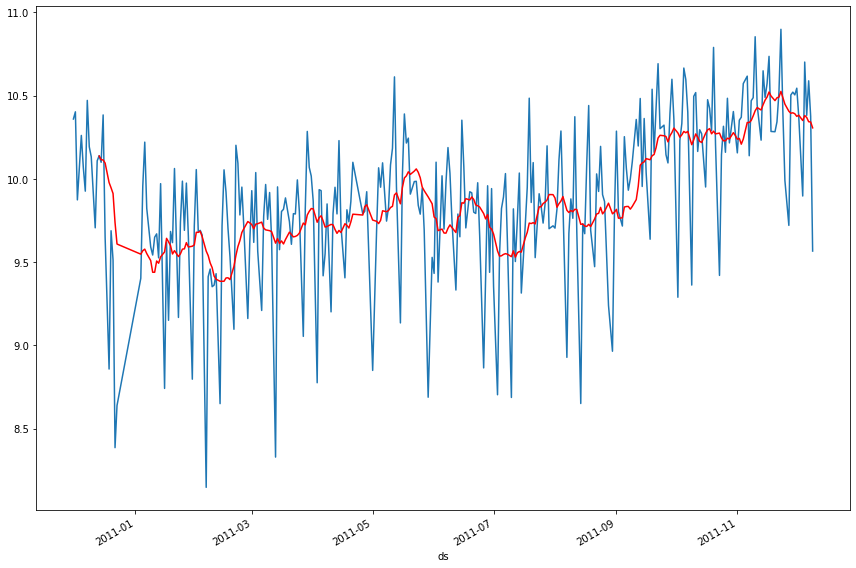

In [0]:
# applying the log
df_log = np.log(df_ts)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, color='r', legend=False)
plt.tight_layout()

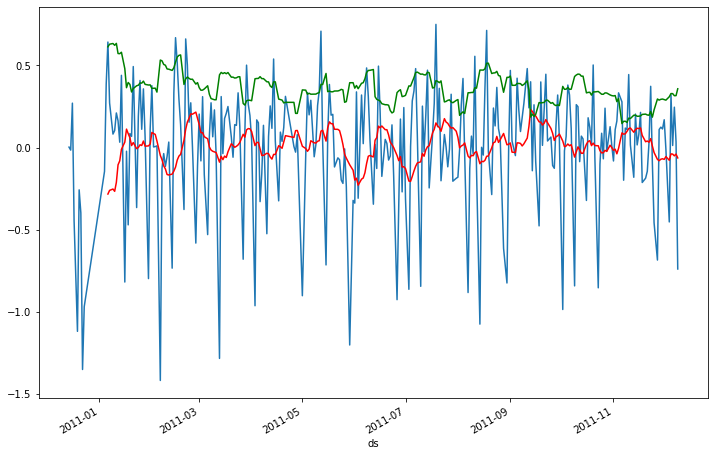

In [0]:
# subtracting the log average from the data
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(12).mean()
std_sub = df_sub.rolling(12).std()

fig, ax = plt.subplots(figsize=(12,8))
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, color='r', legend=False)
std_sub.plot(ax=ax, color='g', legend=False)
plt.show();

In [0]:
# repeating the ADF
X_sub = df_sub.y.values

# applying ADF and printing the result
result_sub = adfuller(X_sub)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result_sub[0]))
print('P Value: {:.10f}'.format(result_sub[1]))
print('Critical Values:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -5.4029
P Value: 0.0000033403
Critical Values:
	1%: -3.4538
	5%: -2.8718
	10%: -2.5723


That's already good enough, but with differencing we can make it even better, and take it as stationary with an even higher level of confidence.

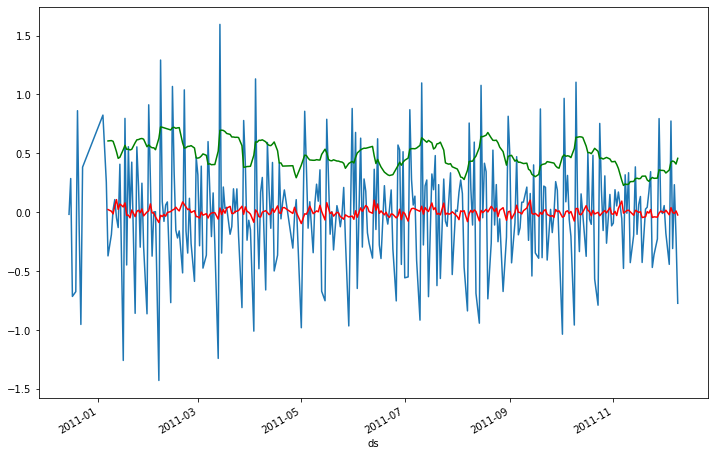

Augmented Dickey–Fuller
Statistical Test: -5.4029
P Value: 0.0000033403
Critical Values:
	1%: -3.4538
	5%: -2.8718
	10%: -2.5723


In [0]:
# applying differencing
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

fig, ax = plt.subplots(figsize=(12,8))
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, color='r', legend=False)
std_diff.plot(ax=ax, color='g', legend=False)
plt.show()

# extracting values only
X_diff = df_diff.y.dropna().values

# applying ADF and printing the result
result_diff = adfuller(X_diff)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result_sub[0]))
print('P Value: {:.10f}'.format(result_sub[1]))
print('Critical Values:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

#### Working on the Stationary Time Series
Now that our Time Series is Stationary, let's work on it.

In [0]:
# reset index to come back to Prophet's format
df_log.reset_index(inplace=True)

In [0]:
# again, setting prediction size to 30
prediction_size = 30
train_df = df_log[:-prediction_size]

In [0]:
# instatiating the model
m = Prophet()

# training the model
m.fit(train_df)

# make predictions
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

forecast.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-12-01,9.888470,9.518400,10.316589,9.888470,9.888470,0.050732,0.050732,0.050732,0.050732,0.050732,0.050732,0.0,0.0,0.0,9.939202
1,2010-12-02,9.884268,9.687581,10.488755,9.884268,9.884268,0.213737,0.213737,0.213737,0.213737,0.213737,0.213737,0.0,0.0,0.0,10.098006
2,2010-12-03,9.880067,9.436346,10.246364,9.880067,9.880067,-0.035694,-0.035694,-0.035694,-0.035694,-0.035694,-0.035694,0.0,0.0,0.0,9.844372
3,2010-12-05,9.871663,8.934636,9.767084,9.871663,9.871663,-0.534179,-0.534179,-0.534179,-0.534179,-0.534179,-0.534179,0.0,0.0,0.0,9.337484
4,2010-12-06,9.867462,9.505306,10.303156,9.867462,9.867462,0.031737,0.031737,0.031737,0.031737,0.031737,0.031737,0.0,0.0,0.0,9.899199


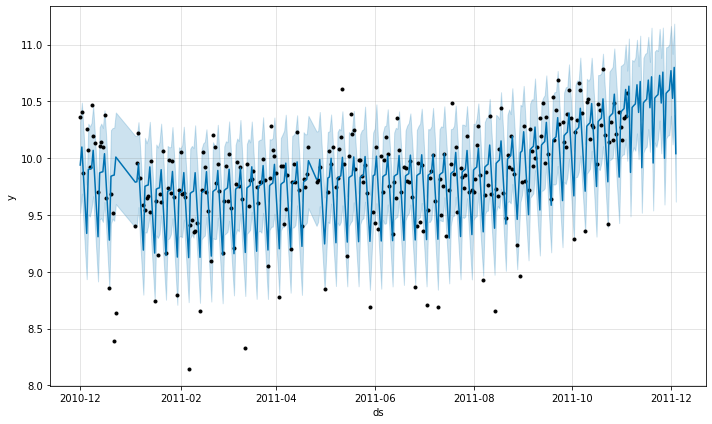

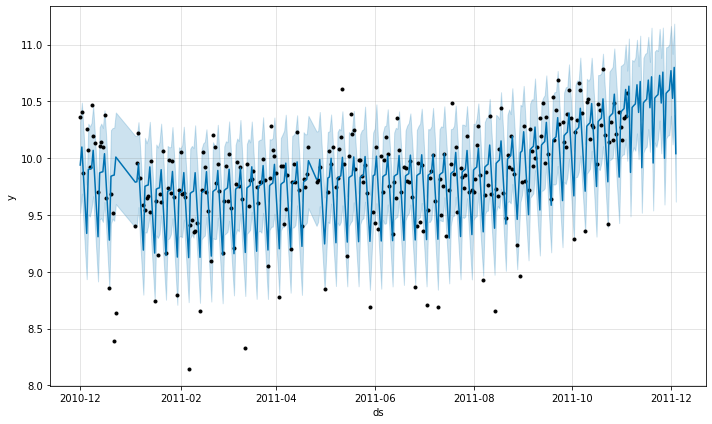

In [0]:
# plotting the forecast
m.plot(forecast)

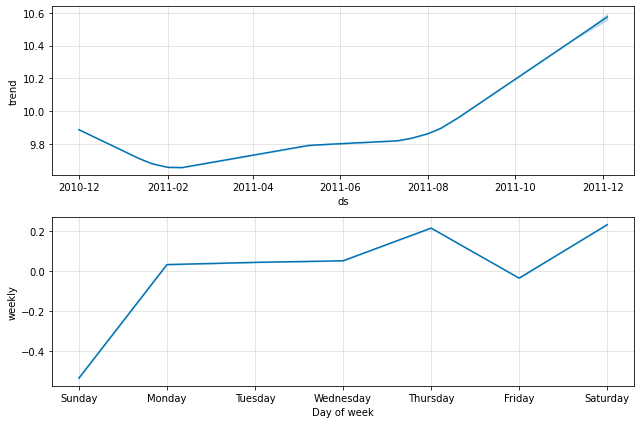

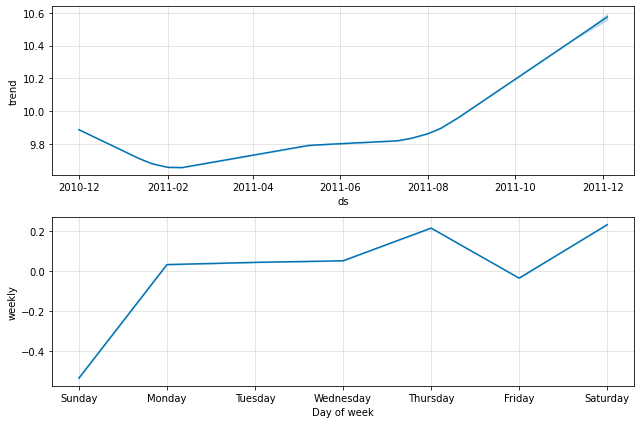

In [0]:
# plotting components
m.plot_components(forecast)

#### Analyzing Components
We can take away some interesting insights from these graphs:
* Confirmation of our daily analysis, showing sales are at their best during weekdays.
* Upward trend.


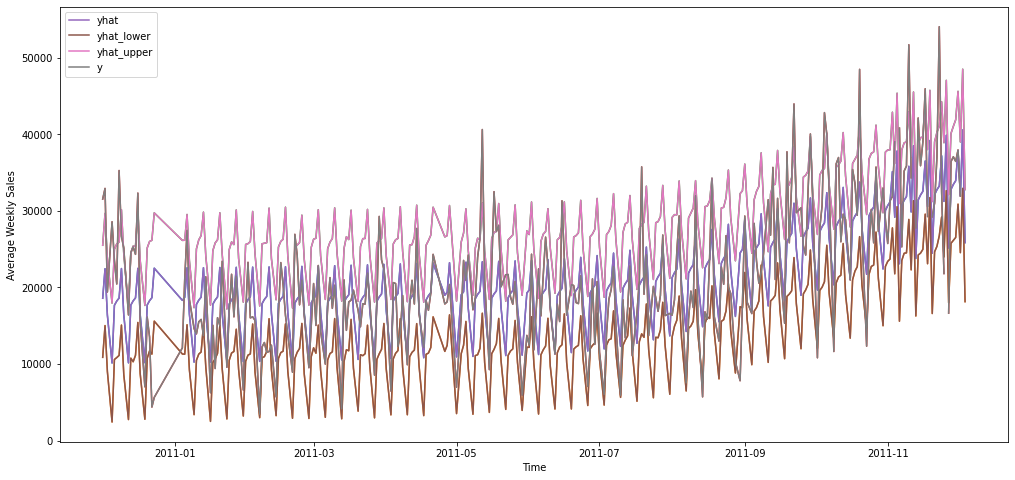

In [0]:
# checking results
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])

plt.xlabel('Time')
plt.ylabel('Average Weekly Sales')
ax.plot(cmp_df['yhat'], label='yhat')
ax.plot(cmp_df['yhat_lower'], label='yhat_lower')
ax.plot(cmp_df['yhat_upper'], label='yhat_upper')
ax.plot(cmp_df['y'], label='y')
ax.legend()
plt.show()

In [0]:
# define a function to make a dataframe containing the predicion and actual values
def make_comparison_dataframe(historical, forecast):
  return forecast.set_index('ds')[['yhat', 'yhat_lower',
                                'yhat_upper']].join(historical.set_index('ds'))
cmp_df = make_comparison_dataframe(df_log, forecast)

# define a function to calculate MAPE and MAE
def calculate_forecast_errors(df_ts, prediction_size):

  df = df_ts.copy()
  df['e'] = df['y'] - df['yhat']
  df['p'] = 100 * df['e'] / df['y']
  predicted_part = df[-prediction_size:]

  error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

  return{'MAPE': error_mean('p'), 'MAE': error_mean('e')}

# print the MAPE and MAE
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
  print(err_name, err_value)

MAPE 1.8562025135871636
MAE 0.1924116454303215


### Conclusions

With and Mean Absolute Percentage Error of less than 2% and an Mean Absolute Error of around 0.19, it's safe to say we have created a model that can become a reliable source of information.

This shows how powerful it is to make predictions on Stationary Data.

Let's see what else we can learn from the data.

In [0]:
# creating a complete dataset
df_final = forecast[['ds', 'yhat']]
df_final.head()

,ds,yhat
0,2010-12-01,9.939202
1,2010-12-02,10.098006
2,2010-12-03,9.844372
3,2010-12-05,9.337484
4,2010-12-06,9.899199


In [0]:
# visualizing the preditctions as tables
df_final['AmountSpentLog'] = df_log['y']
df_final.head()

,ds,yhat,AmountSpentLog
0,2010-12-01,9.939202,10.359233
1,2010-12-02,10.098006,10.402305
2,2010-12-03,9.844372,9.873640
3,2010-12-05,9.337484,10.260550
4,2010-12-06,9.899199,10.067463


In [0]:
# getting the values back to their original scale
df_final['AmountSpent'] = np.exp(df_final['AmountSpentLog'].values)
df_final['AmountSpentPred'] = np.exp(df_final['yhat'].values)
df_final.head()

,ds,yhat,AmountSpentLog,AmountSpent,AmountSpentPred
0,2010-12-01,9.939202,10.359233,31546.98,20727.205659
1,2010-12-02,10.098006,10.402305,32935.45,24294.508560
2,2010-12-03,9.844372,9.873640,19411.87,18851.962929
3,2010-12-05,9.337484,10.260550,28582.51,11355.800122
4,2010-12-06,9.899199,10.067463,23563.71,19914.412532


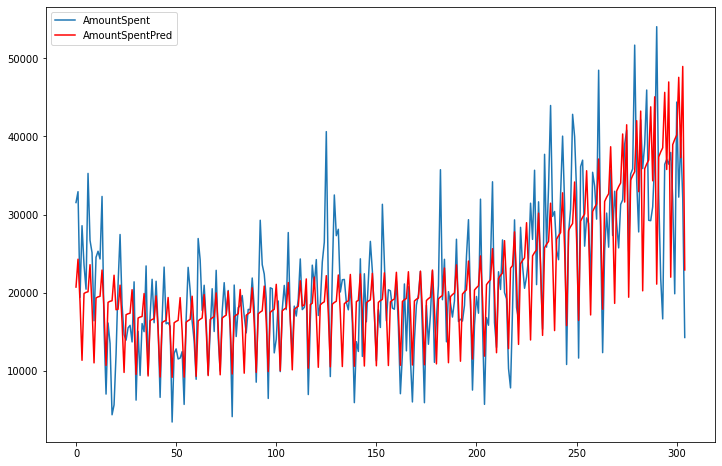

In [0]:
# plotting predictions vs reality
fig, ax = plt.subplots(figsize=(12,8))
df_final['AmountSpent'].plot(ax=ax, legend=('Amount Spent'))
df_final['AmountSpentPred'].plot(ax=ax, color='r', legend={'Predicted'})
plt.show()

We can see that our data tends to underestimate sales values, which is not bad, since business need to plan for worst case scenarios.

If we wanted more optimistic predictions, we could use `yhat_upper` instead of `yhat`.

For more conservative predictions, we could use `yhat_lower`.

# Thank You!

Thank you for your time and attention. I hope this was an informative and interesting project. Should you have any questions or any kind of feedback, feel free to contact me on [LinkedIn](https://www.linkedin.com/in/rafael-n-duarte/), and check out my other projects on [GitHub](https://github.com/rafaelnduarte/portfolio).


[![LinkedIn](https://img.shields.io/badge/LinkedIn-rafaelnduarte-blue.svg)](https://www.linkedin.com/in/rafael-n-duarte)
[![GitHub](https://img.shields.io/badge/GitHub-rafaelnduarte-purple.svg)](https://github.com/rafaelnduarte)

<center><img width="90%" src="https://github.com/rafaelnduarte/Portfolio/blob/master/rafaelnd_banner.png?raw=true"></center>